<a href="https://colab.research.google.com/github/nicas83/ispr22/blob/main/GNicassio_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Midterm 3 - Assignment 1
DATASET (MNIST): http://yann.lecun.com/exdb/mnist/

Train a denoising or a contractive autoencoder on the MNIST dataset: try out different architectures for the autoencoder, including a single layer autoencoder, a deep autoencoder with only layerwise pretraining and a deep autoencoder with fine tuning. It is up to you to decide how many neurons in each layer and how many layers you want in the deep autoencoder. Show an accuracy comparison between the different configurations.

Given the encoding z1 of image x1 (obtained in the hidden layer of the autoencoder) and z2 of image x2, a latent space interpolation is an encoding that is obtained with the linear interpolation z* = a*z1 + (1 - a)*z2, with a in [0, 1]. Perform a latent space interpolation (with some choices of a) using:
- z1 and z2 from the same class
- z1 and z2 from different classes

Once you have the interpolated encoding z* visualize its image reconstructions (obtained through the decoder) and discuss the results.

In [ ]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import Sequential, layers
from keras.layers import Input, Dense, Dropout, Activation, Conv2D, MaxPooling2D, UpSampling2D, Flatten
from keras.callbacks import EarlyStopping
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.optimizers import Adam

After importing all the libraries needed for the experiment, I'll prepare the dataset with the following function.
The function return also a noised dataset with some noise factor given in input.

In [ ]:
def prepare_dataset(add_noise=False, noise_factor=0.5):
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    # We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.
    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.
    x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
    x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
    x_train_noisy = None
    x_test_noisy = None
    if add_noise:
        _noise_factor = noise_factor
        x_train_noisy = x_train + _noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
        x_test_noisy = x_test + _noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
        x_train_noisy = np.clip(x_train_noisy, 0., 1.)
        x_test_noisy = np.clip(x_test_noisy, 0., 1.)

    return x_train, y_train, x_test, y_test, x_train_noisy, x_test_noisy

#Train a Single Layer Autoencoder
Within the following section, the code for training a single layer autoencoder is shown. At the end of the training phase, the model returns an accuracy of 92% on the test set.

In [ ]:
def train_single_layer_autoencoder():
    x_train, y_train, x_test, y_test, x_train_noisy, x_test_noisy = prepare_dataset(True, 0.5)
    y_train = to_categorical(y_train,10)
    y_test = to_categorical(y_test,10)

    input_layer = keras.Input(shape=(784,))
    encoded = Dense(512, activation='relu')(input_layer)
    decoded = Dense(10, activation='softmax')(encoded)

    autoencoder = keras.Model(input_layer, decoded)

    # optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
    autoencoder.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history = autoencoder.fit(x_train_noisy, y_train,
                              epochs=50,
                              batch_size=256,
                              shuffle=True,
                              validation_data=(x_test_noisy, y_test),
                              verbose=0)

    autoencoder.summary()
    loss, accuracy = autoencoder.evaluate(x_test_noisy, y_test)
    print('Accuracy on test set: ', accuracy)
    plt.plot(history.history["accuracy"], label="Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.legend()
    plt.show()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_24 (Dense)            (None, 512)               401920    
                                                                 
 dense_25 (Dense)            (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________
313/313 [==============================] - 1s 3ms/step - loss: 0.4371 - accuracy: 0.9226
Accuracy on test set:  0.9225999712944031


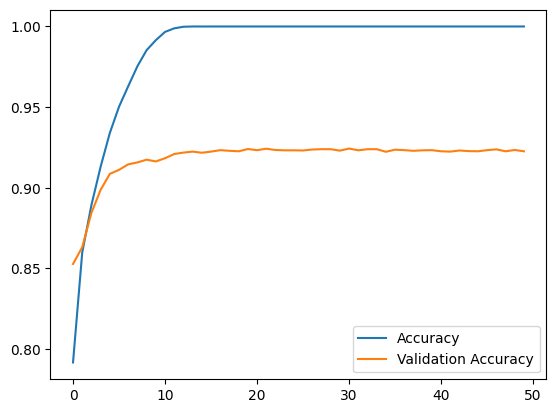

In [ ]:
# execute single layer dataset dataset
train_single_layer_autoencoder()


#Train a Deep Autoencoder
The deep autoencoder is a 3 layers depth for encoder and 2 layers depth for decoder.

In [ ]:
def train_deep_autoencoder(classification=True):
    x_train, y_train, x_test, y_test, x_train_noisy, x_test_noisy = prepare_dataset(add_noise=True)

    y_train = keras.utils.to_categorical(y_train, num_classes=10)
    y_test = keras.utils.to_categorical(y_test, num_classes=10)

    input_layer = keras.Input(shape=(784,))
    encoded_hl1 = Dense(512, activation='relu')(input_layer)
    encoded_hl2 = Dense(256, activation='relu')(encoded_hl1)
    encoded_hl3 = Dense(128, activation='relu')(encoded_hl2)

    decoded_hl1 = Dense(256, activation='relu')(encoded_hl3)
    decoded_hl2 = Dense(512, activation='relu')(decoded_hl1)
    if classification:
        output_layer = Dense(10, activation='softmax')(decoded_hl2)
        loss = 'categorical_crossentropy'
    else:
        output_layer = Dense(10, activation='softmax')(decoded_hl2)
        loss = 'mean_squared_error'

    autoencoder = keras.Model(input_layer, output_layer)
    autoencoder.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
    autoencoder.summary()

    history = autoencoder.fit(x_train_noisy, y_train,
                              epochs=50,
                              batch_size=256,
                              shuffle=True,
                              validation_data=(x_test_noisy, y_test),
                              verbose=0)

    # evaluate model TODO
    loss, accuracy = autoencoder.evaluate(x_test_noisy, y_test)
    print('Accuracy on test set: ', accuracy)
    # plot accuracy
    plt.plot(history.history["accuracy"], label="Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.legend()
    plt.show()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_26 (Dense)            (None, 512)               401920    
                                                                 
 dense_27 (Dense)            (None, 256)               131328    
                                                                 
 dense_28 (Dense)            (None, 128)               32896     
                                                                 
 dense_29 (Dense)            (None, 256)               33024     
                                                                 
 dense_30 (Dense)            (None, 512)               131584    
                                                                 
 dense_31 (Dense)            (None, 10)                5130

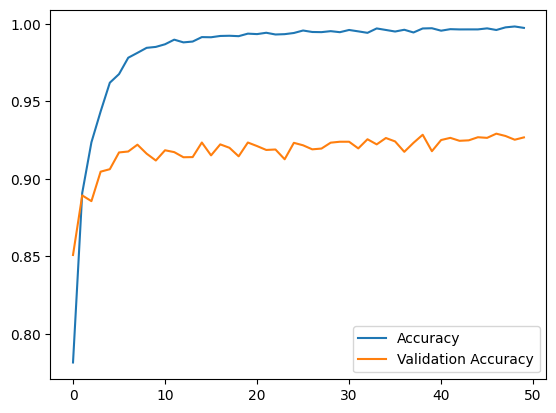

In [ ]:
train_deep_autoencoder()

#Train Deep Autoencoder with fine tuning

There are many aspects of the learning algorithm that can be explored for improvement.

The point of biggest leverage is the learning rate, such as evaluating the impact that smaller or larger values of the learning rate may have, as well as schedules that change the learning rate during training. I tried using lower learning rates but the result did not improve.
I also used different algorithms (Adam and SGD) getting better accuracy results with Adam.

Another approach that can rapidly increase the accuracy of the model could be increasing the depth of the network.
the code below shows an architecture with more layers than those present in the "train a deep autoencoder" experiment.
However, increasing the depth of the network did not have the desired effect while adding a Dropout layer after each Dense layer and increase the number of neurons in each layer led to a better convergency.

Another action was to increase the training epochs which improved a little the final accuracy of the model.
An important improvement was achieved by considering a CNN as an autoencoder architecture, as demonstrated in the next section.
Some of the experiments mentioned were tested and run on my Macbook Pro M1, as running on Colab resulted in memory fault numbers.
The results of the executions on the personal PC are reported in the "**Conclusions**" section

In [ ]:
def training_fine_tuning():
    x_train, y_train, x_test, y_test, x_train_noisy, x_test_noisy = prepare_dataset(add_noise=True)

    y_train = keras.utils.to_categorical(y_train, num_classes=10)
    y_test = keras.utils.to_categorical(y_test, num_classes=10)

    input_layer = keras.Input(shape=(784,))
    encoded_hl1 = Dense(512, activation='relu')(input_layer)
    encoded_hl2 = Dropout(0.3)(encoded_hl1)
    encoded_hl3 = Dense(256, activation='relu')(encoded_hl2)
    encoded_hl4 = Dropout(0.3)(encoded_hl3)
    encoded_hl5 = Dense(128, activation='relu')(encoded_hl4)
    encoded_hl6 = Dropout(0.3)(encoded_hl5)
    encoded_hl7 = Dense(64, activation='relu')(encoded_hl6)

    decoded_hl1 = Dense(128, activation='relu')(encoded_hl7)
    decoded_hl2 = Dropout(0.3)(decoded_hl1)
    decoded_hl3 = Dense(256, activation='relu')(decoded_hl2)
    decoded_hl4 = Dropout(0.3)(decoded_hl3)
    decoded_hl5 = Dense(512, activation='relu')(decoded_hl4)
    output_layer = Dense(10, activation='softmax')(decoded_hl5)

    autoencoder = keras.Model(input_layer, output_layer)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), 
                        loss='categorical_crossentropy', metrics=['accuracy'])
    autoencoder.summary()

    history = autoencoder.fit(x_train_noisy, y_train,
                              epochs=30,
                              batch_size=256,
                              shuffle=True,
                              validation_data=(x_test_noisy, y_test),
                              verbose=0)


    # evaluate model TODO
    loss, accuracy = autoencoder.evaluate(x_test_noisy, y_test)
    print('Accuracy on test set: ', accuracy)
    # plot accuracy
    plt.plot(history.history["accuracy"], label="Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.legend()
    plt.show()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_8 (Dense)             (None, 512)               401920    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0   

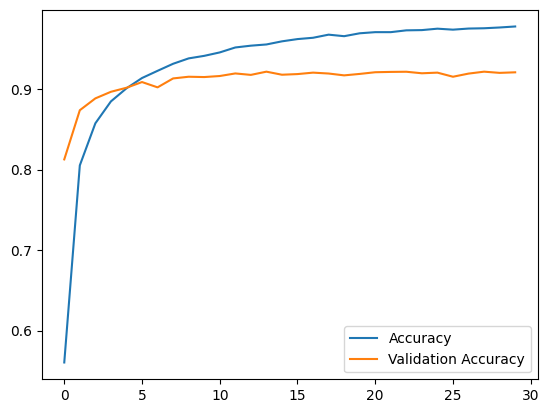

In [ ]:
training_fine_tuning()

#Train Deep Autoencoder with Layer-wise Pretraining
In this part of the experiment I reuse the 3-level architecture of the "Deep Autoencoder" experiment by applying the layer-wise pretraing technique which involves training one layer at a time, reusing the parameters of the previous layer. With each addition, the previous layer is no longer trained (property trainable = false) 

In [ ]:
def train_deep_autoencoder_pretraining_wise():
    x_train, y_train, x_test, y_test, x_train_noisy, x_test_noisy = prepare_dataset(add_noise=True)
    y_train = keras.utils.to_categorical(y_train)
    y_test = keras.utils.to_categorical(y_test)

    # Pretrain the layers of the encoder
    weights_dict = {}
    hidden_layers = [512, 256, 128]
    num_hl = len(hidden_layers)
    # curr starts from 1  and goes up to number of hidden layers =1
    for curr in range(1, num_hl + 1):
        model_layers = []
        _input = Input(shape=(784,))
        model_layers.append(_input)
        prev_layer = _input

        size_stack = []
        # ========encoder==========
        _i = 1
        for enc_index in range(1, curr + 1):
            enc_layer_name = 'enc_' + str(_i)
            size_stack.append(hidden_layers[enc_index - 1])
            _layer = Dense(hidden_layers[enc_index - 1], activation='relu', use_bias=True, name=enc_layer_name)
            target_layer_name = enc_layer_name
            op1 = _layer(prev_layer)
            prev_layer = op1
            model_layers.append(op1)
            _i += 1

        # one extra thing (last layer) added to stack - get rid of it
        size_stack.pop()

        # =====decoder==========
        _i = num_hl * 2 - (_i - 1) + 1
        while len(size_stack) > 0:
            units_num = size_stack.pop(-1)
            dec_layer_name = 'dec_' + str(_i)
            _i += 1

            op1 = Dense(units_num, activation='relu', name=dec_layer_name)(prev_layer)
            prev_layer = op1
            model_layers.append(op1)

        # output layer
        _i = num_hl * 2
        out_layer_name = 'dec_' + str(_i)
        op2 = Dense(10, activation='softmax', name=out_layer_name)(prev_layer)

        model_layers.append(op2)
        model = keras.Model(inputs=model_layers[0], outputs=model_layers[-1])

        # setting the weight of previous layers and set the layer itself to not trainable
        for l in model.layers:
            if l.name in weights_dict.keys():
                l.trainable = False
                wb = weights_dict[l.name]
                l.set_weights(wb)

        # compile and training the current layer of autoencoder
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        history = model.fit(x_train_noisy, y_train, batch_size=256, epochs=15, 
                            verbose=0, 
                            validation_data=(x_test_noisy, y_test))

        # After fitting save the weights of the new layer added
        for l in model.layers:
            if 'enc' in l.name or 'dec' in l.name:
                _id = l.name
                weights_dict[_id] = l.get_weights()

    loss, accuracy = model.evaluate(x_test_noisy, y_test)
    print('Accuracy on test set: ', accuracy)
    plt.plot(history.history["accuracy"], label="Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.legend()
    plt.show()
    print(model.summary())

313/313 [==============================] - 1s 4ms/step - loss: 0.6699 - accuracy: 0.9210
Accuracy on test set:  0.9210000038146973


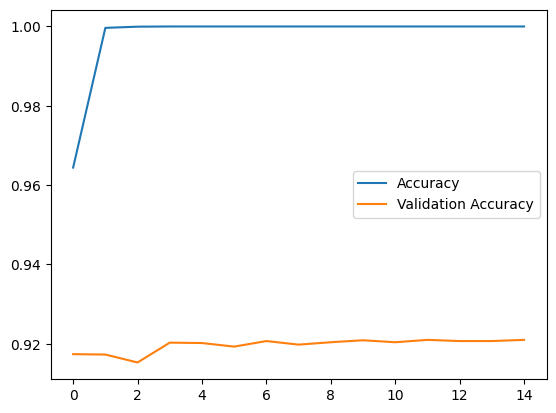

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 784)]             0         
                                                                 
 enc_1 (Dense)               (None, 512)               401920    
                                                                 
 enc_2 (Dense)               (None, 256)               131328    
                                                                 
 enc_3 (Dense)               (None, 128)               32896     
                                                                 
 dec_4 (Dense)               (None, 256)               33024     
                                                                 
 dec_5 (Dense)               (None, 512)               131584    
                                                                 
 dec_6 (Dense)               (None, 10)                5130

In [ ]:
train_deep_autoencoder_pretraining_wise()

# Train Deep Convolutional Autoencoder
I decide to try a different type of autoencoder architecture, this time using a Convolutional Neural Network that is well the image processing.
Some considerations on the architecture: the number of epochs is significantly reduced compared to previous experiments because the accuracy reaches a level equal to 99% right from the first epochs.
Two trials were performed, increasing the noise level of the dataset. In both cases the accuracy has not affected. I show only one result, with noise_factor=0.5, due to the Colab performance (I encountered several memory faults while running the experiments). Other tests mentioned was perfomed on my personal Apple Macbook M1 Pro.

In [ ]:
def prepare_dataset_cnn(noise_factor):
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # Scale images to the [0, 1] range
    x_train = x_train.astype("float32") / 255
    x_test = x_test.astype("float32") / 255
    x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
    x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

    _noise_factor = noise_factor
    x_train_noisy = x_train + _noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
    x_test_noisy = x_test + _noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

    x_train_noisy = np.clip(x_train_noisy, 0., 1.)
    x_test_noisy = np.clip(x_test_noisy, 0., 1.)

    # convert class vectors to binary class matrices
    x_train = to_categorical(x_train, num_classes=10)
    x_test = to_categorical(x_test, num_classes=10)

    return x_train_noisy, x_train, x_test_noisy, x_test

In [ ]:
def train_deep_autoencoder(noise_factor):
    # get data from mnist with noise factor
    x_train_noisy, x_train, x_test_noisy, x_test = prepare_dataset_cnn(noise_factor)

    # plot sample noisy
    plt.figure(figsize=(10, 2))
    for i in range(1, 5 + 1):
        ax = plt.subplot(1, 5, i)
        plt.imshow(x_test_noisy[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

    input_img = keras.Input(shape=(28, 28, 1))

    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    # at this point the representation is (4, 4, 8) i.e. 128-dimensional

    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(16, (3, 3), activation='relu')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(10, (3, 3), activation='relu', padding='same')(x)
    x = layers.Dropout(0.5)(x)
    decoded = layers.Dense(10, activation='softmax')(x)

    autoencoder = keras.Model(input_img, decoded)
    autoencoder.summary()
    autoencoder.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history = autoencoder.fit(x_train_noisy, x_train,
                              epochs=5,
                              batch_size=256,
                              shuffle=True,
                              validation_split=0.2,
                              validation_data=(x_test_noisy, x_test),
                              verbose=0)

    score = autoencoder.evaluate(x_test_noisy, x_test)
    print("Test loss:", score[0])
    print("Test accuracy:", score[1])
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.plot(history.history["accuracy"], label="Accuracy")
    plt.legend()
    plt.show()

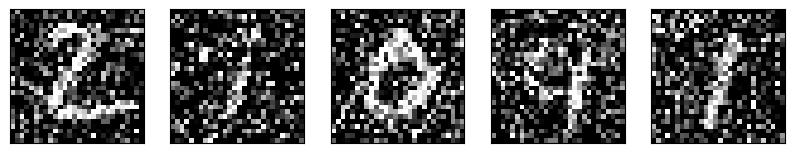

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 8)           584   

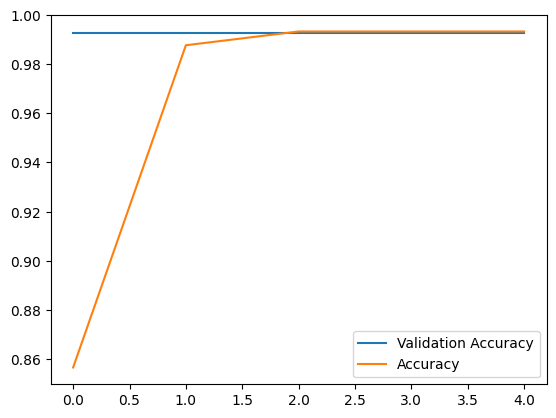

In [ ]:
train_deep_autoencoder(0.5)

#Latent Space Interpolation
In the latent space interpolation experiment a deep convolutional network composed of 8 encoding and 7 decoding layers was configured. The alpha parameter was selected randomly. The experiments below showns interpolation in the same class (same number for each z1 and z2) and different classes (different number for z1 and z2).
While the interpolation is clearly visibile with z1,z2 ∈ different classes, in the case of the same class nothing happens and the number is still the same across all the interpolation vectors applied.

In [ ]:
def latent_space_interpolation(class1, class2):
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # Scale images to the [0, 1] range
    x_train = x_train.astype("float32") / 255
    x_test = x_test.astype("float32") / 255
    x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
    x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

    input = Input(shape=(x_train.shape[1:]))
    encoded = Conv2D(16, (3, 3), activation='relu', padding='same')(input)
    encoded = MaxPooling2D((2, 2), padding='same')(encoded)
    encoded = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    encoded = MaxPooling2D((2, 2), padding='same')(encoded)
    encoded = Conv2D(8, (3, 3), strides=(2, 2), activation='relu', padding='same')(encoded)
    encoded = Flatten()(encoded)

    decoded = layers.Reshape((4, 4, 8))(encoded)
    decoded = Conv2D(8, (3, 3), activation='relu', padding='same')(decoded)
    decoded = UpSampling2D((2, 2))(decoded)
    decoded = Conv2D(8, (3, 3), activation='relu', padding='same')(decoded)
    decoded = UpSampling2D((2, 2))(decoded)
    decoded = Conv2D(16, (3, 3), activation='relu')(decoded)
    decoded = UpSampling2D((2, 2))(decoded)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoded)
    # x = layers.Dropout(0.5)(decoded)
    # decoded = layers.Dense(10, activation='softmax')(decoded)

    autoencoder = keras.Model(input, decoded)

    # encoder model
    encoder = keras.Model(inputs=autoencoder.input, outputs=autoencoder.layers[6].output)
    print ('Encoder architecture')
    encoder.summary()

    # decoder model
    encoded_input = Input(shape=(128,))

    deco = autoencoder.layers[-8](encoded_input)
    deco = autoencoder.layers[-7](deco)
    deco = autoencoder.layers[-6](deco)
    deco = autoencoder.layers[-5](deco)
    deco = autoencoder.layers[-4](deco)
    deco = autoencoder.layers[-3](deco)
    deco = autoencoder.layers[-2](deco)
    deco = autoencoder.layers[-1](deco)
    # create the decoder model
    decoder = keras.Model(encoded_input, deco)
    print('Decoder architecture')
    decoder.summary()

    # autoencoder.summary()
    autoencoder.compile(optimizer='SGD', loss='mse', metrics=['accuracy'])

    autoencoder.fit(x_train, x_train,
                    epochs=10,
                    batch_size=256,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=0,
                    validation_data=(x_test, x_test))

    # Random Image 1
    test_image1 = x_test[class1].reshape(1, 28, 28, 1)
    # Random Image 2
    test_image2 = x_test[class2].reshape(1, 28, 28, 1)
    encoded_img1 = encoder.predict(test_image1)
    encoded_img2 = encoder.predict(test_image2)

    interpolated_images = interpolate_points(encoded_img1.flatten(), encoded_img2.flatten())
    interpolated_orig_images = interpolate_points(test_image1.flatten(), test_image2.flatten())

    interpolated_images.shape
    num_images = 15
    np.random.seed(42)
    plt.figure(figsize=(30, 8))

    for i, image_idx in enumerate(interpolated_images):
        ax = plt.subplot(5, num_images, i + 1)
        plt.imshow(interpolated_images[i].reshape(16, 8))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title("Encoded: {}".format(i))

        ax = plt.subplot(5, num_images, num_images + i + 1)
        plt.imshow(decoder.predict(interpolated_images[i].reshape(1, 128)).reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title("Latent: {}".format(i))

        ax = plt.subplot(5, num_images, 2 * num_images + i + 1)
        plt.imshow(interpolated_orig_images[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title("Image: {}".format(i))

    plt.show()


def interpolate_points(z1, z2, n_steps=15):
    # interpolate ratios between the points
    ratios = np.linspace(0, 1, num=n_steps)
    # linear interpolate vectors
    vectors = list()
    for a in ratios:
        v = (1.0 - a) * z1 + a * z2
        vectors.append(v)
    return np.asarray(vectors)

Encoder architecture
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 4,

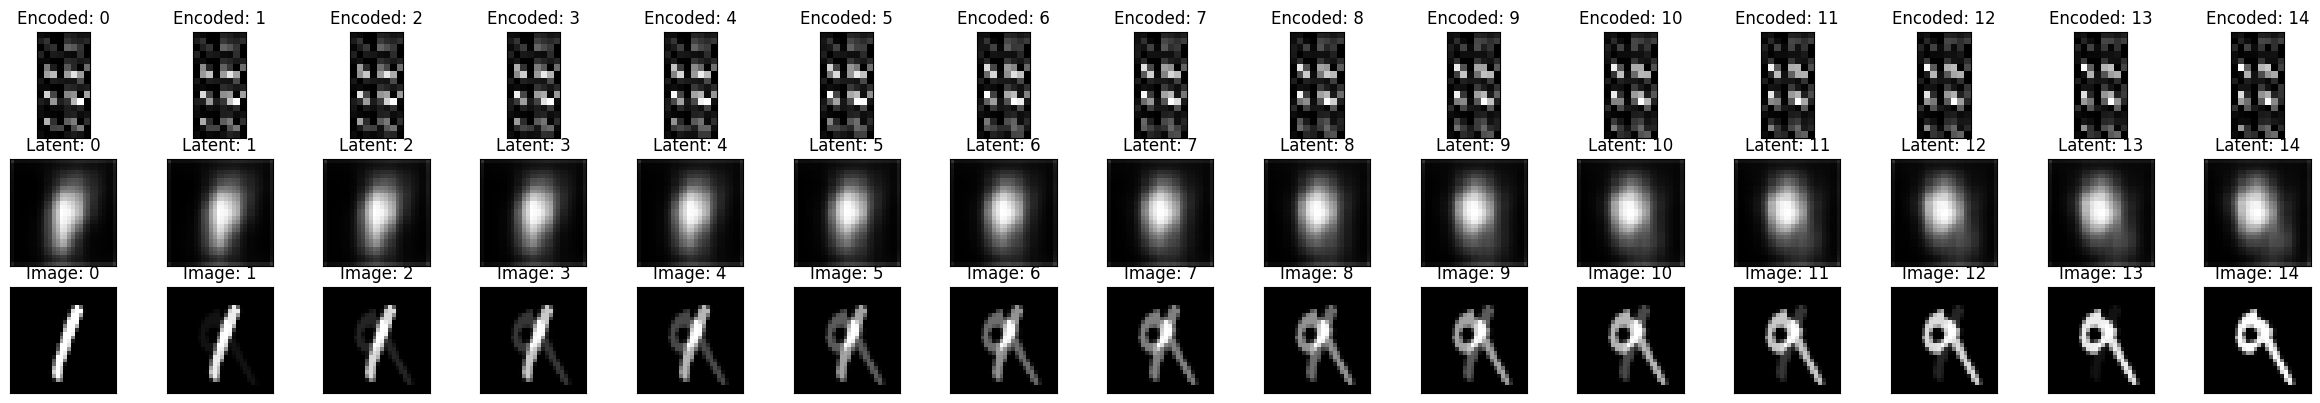

In [ ]:
# images from different classes
latent_space_interpolation(5,7)

Encoder architecture
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_22 (Conv2D)          (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_23 (Conv2D)          (None, 4,

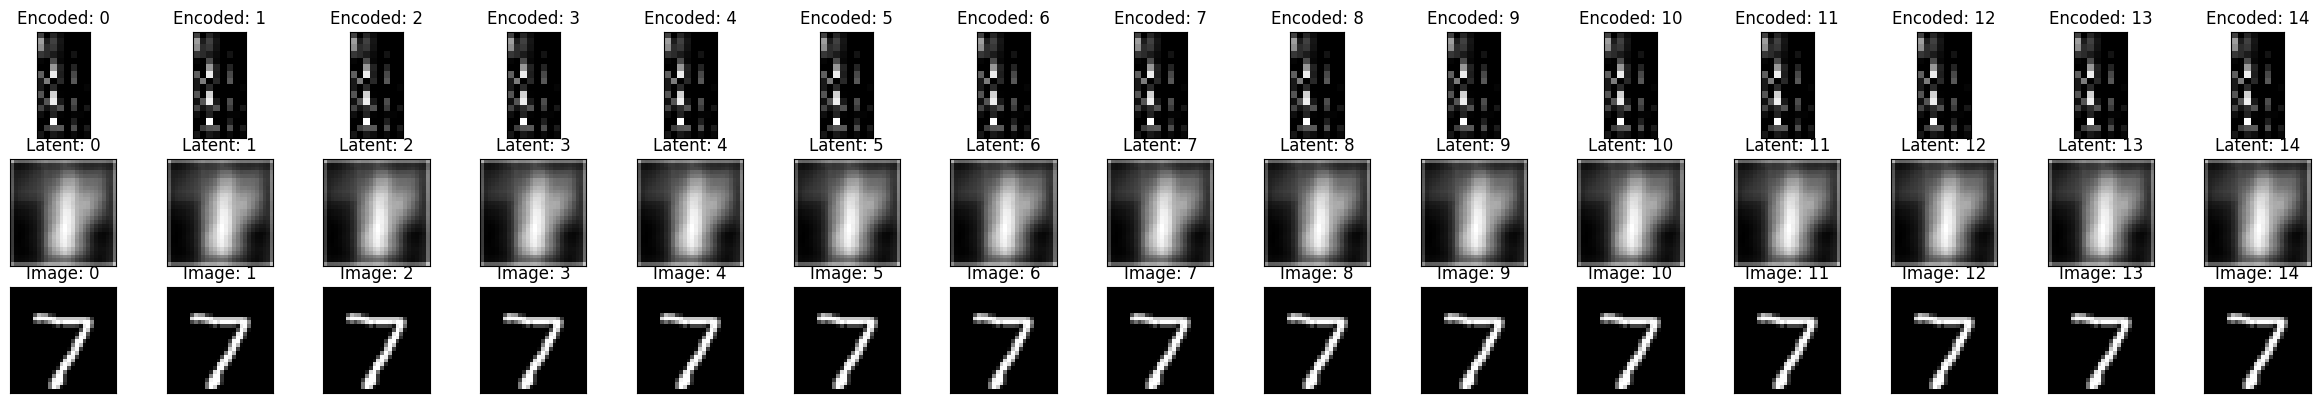

In [ ]:
# images from same class
latent_space_interpolation(0,0)

#Conclusions
The experiments discussed above, based on the different architectures used, led to different final results in terms of model accuracy on the test set. In particular: 

*   Single Layer Autoencoder: 0.9225999712944031
*   Deep Autoencoder: 0.9266999959945679
* Deep Autoencoder with FT: 0.9208999872207642
* Deep Autoencoder with LW-Pretraining: 0.9210000038146973
* Deep CNN Autoencoder: 0.9927506446838379

As described in the section dedicated to the FT, the local test on 100 epochs improved the accuracy


> Accuracy on test set:0.9269999861717224

The difference between the Train Accuracy (alwasy close to 1) and the Validation Accuracy is due to the some overfitting.
Other experiments were done on my personal laptop, trying to change the number of neurons in each layer. The results showed that with few neurons (128, 64, 32) the accuracy of each experiment was in the range of 87-90%. Using a structured parameter search approach, such as grid search, would have led to a precise definition of the correct parameters to use, including the hidden neurons within each layer.

Using a CNN proves to be the best architectural choice for image processing. However, high execution times could lead to giving up greater accuracy in favor of reduced execution performance.

In the "Latent Space Interpolation" experiment, while the interpolation is clearly visibile with z1,z2 ∈ different classes, in the case of the same class nothing happens and the number is still the same across all the interpolation vectors applied.


